# Load Packages

In [1]:
import pickle
import pandas as pd
import sys
sys.path.insert(0, '..') # Needed to import gmmglm
from gmmglm import gmmglm
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
import scipy.stats as stats

In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# Link Functions

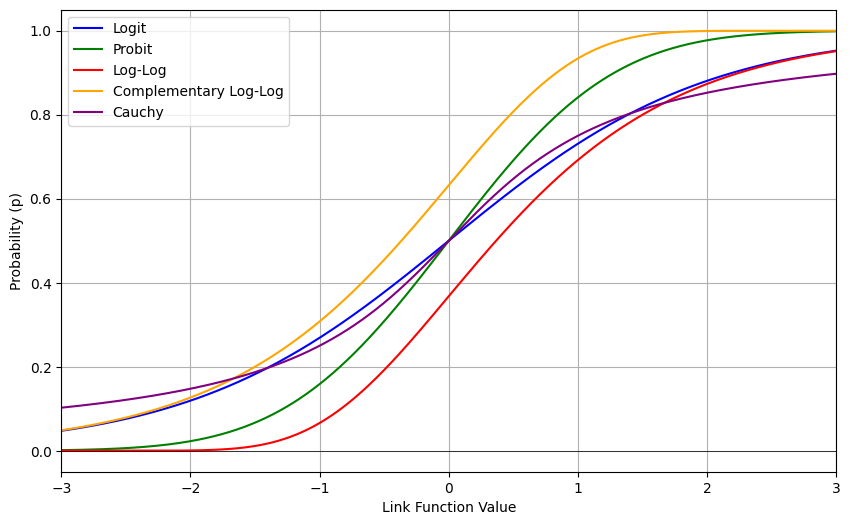

In [3]:
# Generate probability values from 0 to 1
p = np.linspace(.000000000000001, 0.999999999999999, 5000)  # Avoid 0 and 1 to prevent log(0)

# Logit link function
logit = np.log(p / (1 - p))

# Probit link function (inverse CDF of standard normal)
probit = stats.norm.ppf(p)

# Log-Log link function
log_log = -np.log(-np.log(p))

# Complementary log-log (cloglog) link function
cloglog = np.log(-np.log(1 - p))
cauchy = stats.cauchy.ppf(p)

# Plot all link functions
plt.figure(figsize=(10, 6))
plt.plot(logit, p, label='Logit', color='blue')
plt.plot(probit, p, label='Probit', color='green')
plt.plot(log_log, p, label='Log-Log', color='red')
plt.plot(cloglog, p, label='Complementary Log-Log', color='orange')
plt.plot(cauchy, p, label='Cauchy', color='purple')

# Labels and title
plt.ylabel('Probability (p)')
plt.xlabel('Link Function Value')
plt.axhline(0, color='black',linewidth=0.5)

plt.legend()
plt.grid(True)
plt.xlim(-3,3)
plt.savefig("../regression_files/regression_figures/linkfunctions.png")

# Load files

In [69]:
diag = pd.read_csv("../regression_files/regression_results/csv/model_selection_diag.csv")
spherical = pd.read_csv("../regression_files/regression_results/csv/model_selection_spherical.csv")
full = pd.read_csv("../regression_files/regression_results/csv/model_selection_full.csv")
tied = pd.read_csv("../regression_files/regression_results/csv/model_selection_tied.csv")
nocluster = pd.read_csv("../regression_files/regression_results/csv/model_selection_nocluster.csv")

# Data Engineering

In [58]:
diag[["cov","n","pca"]] = diag["model"].str.split("_", expand=True)
diag["pca"] = (diag["pca"]=="pca")*1
diag["n"] = diag["n"].astype(int)
spherical[["cov","n","pca"]] = spherical["model"].str.split("_", expand=True)
spherical["pca"] = (spherical["pca"]=="pca")*1
spherical["n"] = spherical["n"].astype(int)
full[["cov","n","pca"]] = full["model"].str.split("_", expand=True)
full["pca"] = (full["pca"]=="pca")*1
full["n"] = full["n"].astype(int)
tied[["cov","n","pca"]] = tied["model"].str.split("_", expand=True)
tied["pca"] = (tied["pca"]=="pca")*1
tied["n"] = tied["n"].astype(int)

In [68]:
combined = pd.concat([diag,spherical,full,tied], ignore_index=True)

combined_extra = pd.concat([combined, nocluster], ignore_index=True)

# Analysis

## Combined

In [8]:
combined.sort_values(by="mavg", ascending=False)

,model,mavg,glm_family,cov,n,pca
233,full_3,0.719126,loglog,full,3,0
113,spherical_2,0.716301,loglog,spherical,2,0
223,full_2,0.716286,loglog,full,2,0
390,tied_8,0.716068,logit,tied,8,0
260,full_6,0.716053,logit,full,6,0
...,...,...,...,...,...,...
437,tied_12_pca,0.627393,cauchy,tied,12,1
436,tied_12_pca,0.626107,probit,tied,12,1
167,spherical_7_pca,0.626046,cauchy,spherical,7,1
422,tied_11,0.624590,cauchy,tied,11,0


In [9]:
combined_cov = combined.groupby('cov')['mavg'].mean().reset_index()
combined_n = combined.groupby('n')['mavg'].mean().reset_index()
combined_glm = combined.groupby('glm_family')['mavg'].mean().reset_index()
combined_n_pca = combined.groupby(['n','pca'])['mavg'].mean().reset_index()
combined_glm_pca = combined.groupby(['glm_family','pca'])['mavg'].mean().reset_index()
combined_pca = combined.groupby(['pca'])['mavg'].mean().reset_index()
combined_n_cov = combined.groupby(['n','cov'])['mavg'].mean().reset_index()

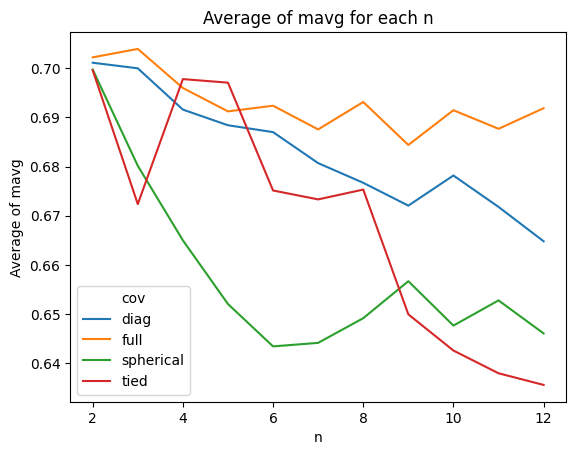

In [10]:
sns.lineplot(x='n', y='mavg', hue="cov", data=combined_n_cov)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
#plt.show()
plt.savefig("../regression_files/regression_figures/mavg/n_cov.png")

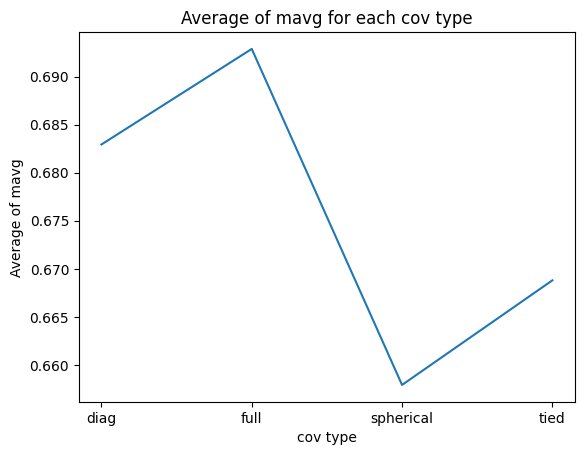

In [11]:
sns.lineplot(x='cov', y='mavg', data=combined_cov)

# Add labels and title
plt.xlabel('cov type')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each cov type')
#plt.show()
plt.savefig("../regression_files/regression_figures/mavg/cov.png")

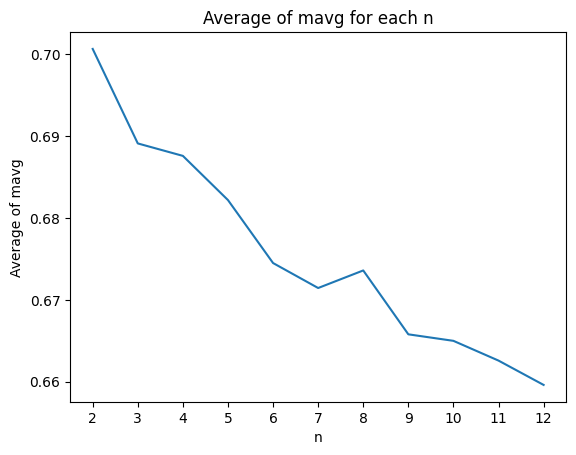

In [12]:
sns.lineplot(x='n', y='mavg', data=combined_n)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
plt.xticks(ticks=combined_n['n'].values, labels=combined_n['n'].values)
#plt.show()
plt.savefig("../regression_files/regression_figures/mavg/n.png")

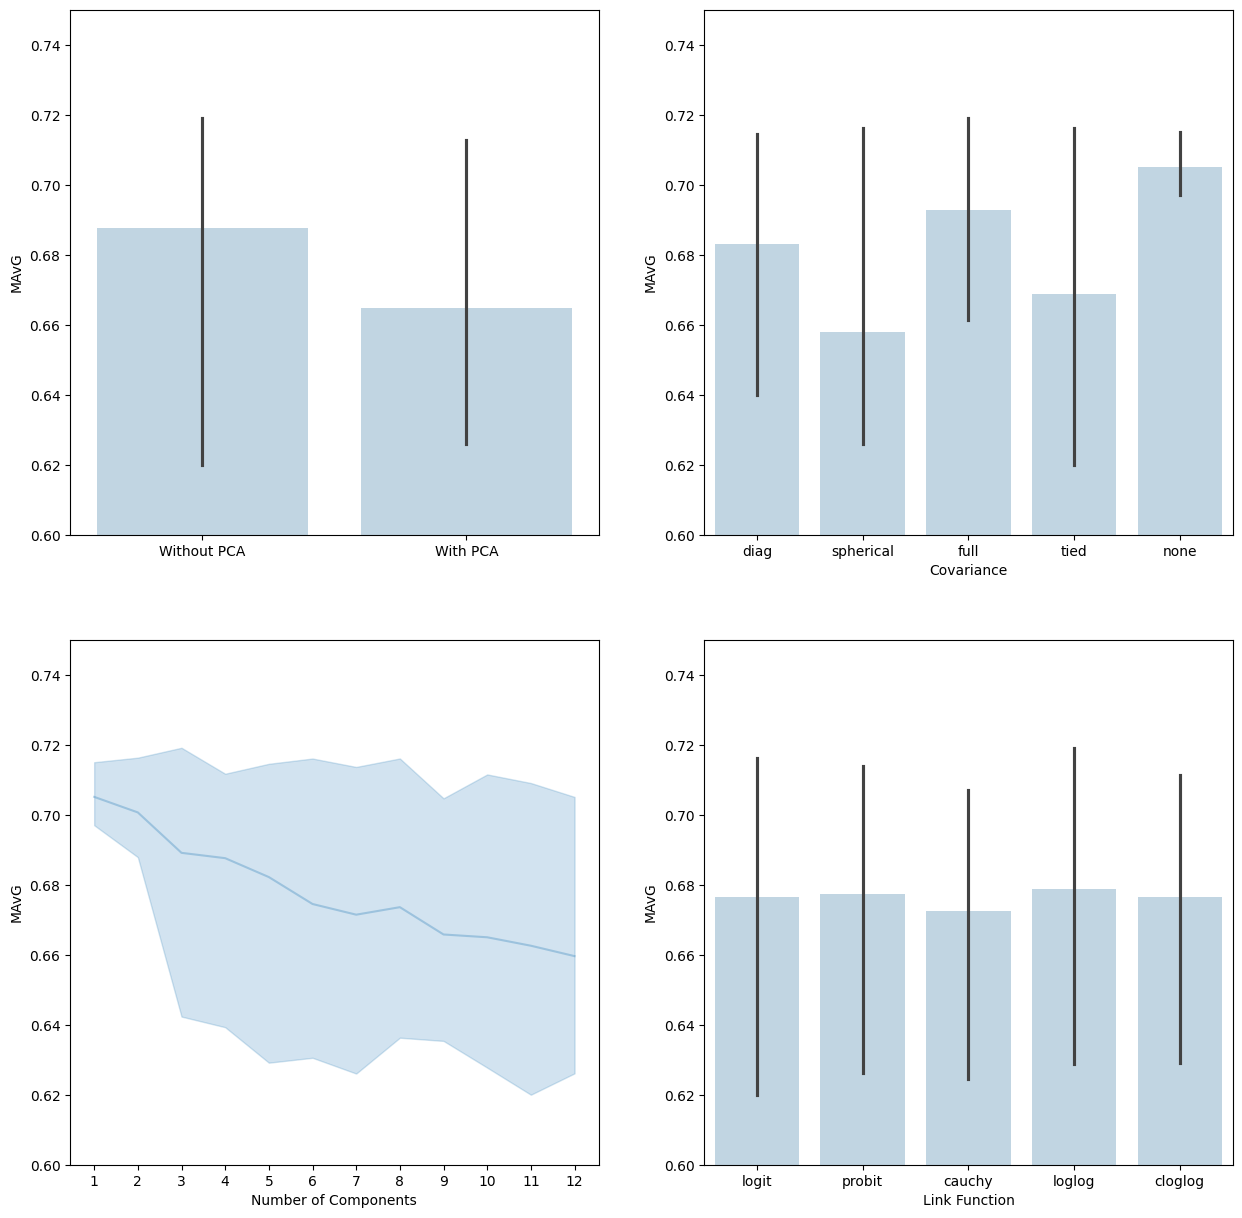

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
sns.barplot(x='pca', y='mavg', errorbar=lambda x: (x.min(), x.max()), alpha=0.3, data=combined_extra, 
             ax=axs[0,0])
axs[0,0].set_ylabel("MAvG")
axs[0,0].set_xlabel("")
axs[0,0].set_xticklabels(["Without PCA", "With PCA"])
axs[0,0].set_ylim(0.6,0.75)

sns.barplot(x='cov', y='mavg', errorbar=lambda x: (x.min(), x.max()), alpha=0.3, data=combined_extra, 
             ax=axs[0,1])
axs[0,1].set_ylabel("MAvG")
axs[0,1].set_xlabel("Covariance")
axs[0,1].set_ylim(0.6,0.75)

sns.lineplot(x='n', y='mavg', errorbar=lambda x: (x.min(), x.max()), alpha=0.3, data=combined_extra, 
             ax=axs[1,0])
handles, _ = axs[0,1].get_legend_handles_labels()
axs[1,0].set_ylabel("MAvG")
axs[1,0].set_xlabel("Number of Components")
axs[1,0].set_ylim(0.6,0.75)
axs[1,0].set_xticks(np.arange(1,13,1))


sns.barplot(x='glm_family', y='mavg', errorbar=lambda x: (x.min(), x.max()), alpha=0.3, data=combined_extra, 
             ax=axs[1,1])
axs[1,1].set_ylabel("MAvG")
axs[1,1].set_xlabel("Link Function")
axs[1,1].set_ylim(0.6,0.75)
plt.savefig("../regression_files/regression_figures/mavg/mavg_analysis.png")

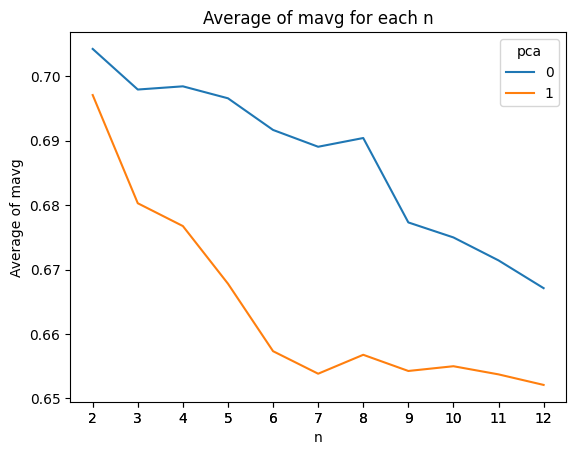

In [14]:
sns.lineplot(x='n', y='mavg', hue="pca", data=combined_n_pca)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
plt.xticks(ticks=combined_n_pca['n'].values, labels=combined_n_pca['n'].values)
plt.savefig("../regression_files/regression_figures/mavg/n_pca.png")

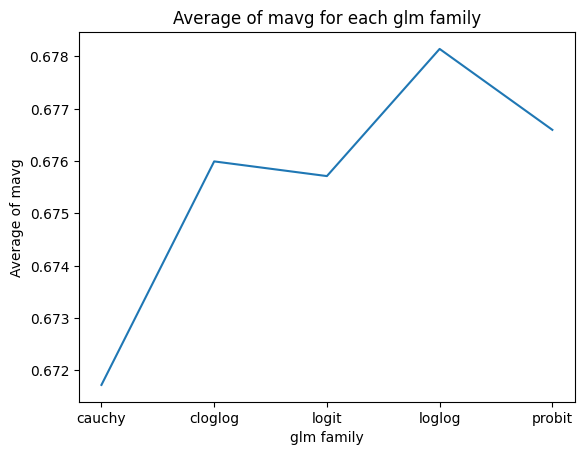

In [15]:
sns.lineplot(x='glm_family', y='mavg', data=combined_glm)

# Add labels and title
plt.xlabel('glm family')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each glm family')
plt.savefig("../regression_files/regression_figures/mavg/glm.png")

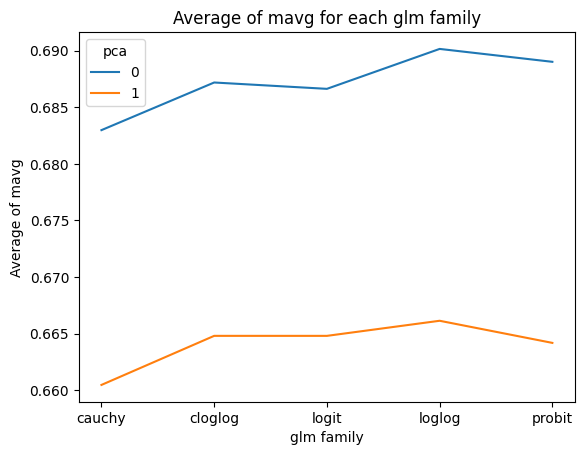

In [16]:
sns.lineplot(x='glm_family', y='mavg', hue="pca", data=combined_glm_pca)

# Add labels and title
plt.xlabel('glm family')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each glm family')
plt.savefig("../regression_files/regression_figures/mavg/glm_pca.png")

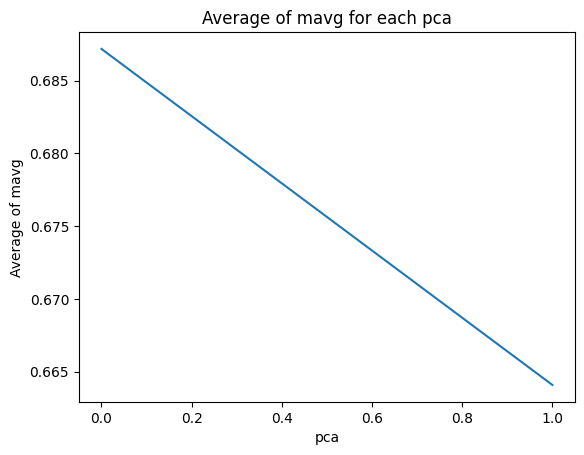

In [17]:
sns.lineplot(x='pca', y='mavg', data=combined_pca)

# Add labels and title
plt.xlabel('pca')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each pca')
plt.savefig("../regression_files/regression_figures/mavg/pca.png")

## Spherical

In [18]:
spherical.sort_values(by="mavg", ascending=False)

,model,mavg,glm_family,cov,n,pca
3,spherical_2,0.716301,loglog,spherical,2,0
4,spherical_2,0.709372,cloglog,spherical,2,0
9,spherical_2_pca,0.704555,cloglog,spherical,2,1
16,spherical_3_pca,0.702548,probit,spherical,3,1
0,spherical_2,0.701144,logit,spherical,2,0
...,...,...,...,...,...,...
88,spherical_10_pca,0.629611,loglog,spherical,10,1
39,spherical_5_pca,0.629154,cloglog,spherical,5,1
56,spherical_7_pca,0.628282,probit,spherical,7,1
87,spherical_10_pca,0.627970,cauchy,spherical,10,1


In [19]:
spherical_n = spherical.groupby('n')['mavg'].mean().reset_index()
spherical_glm = spherical.groupby('glm_family')['mavg'].mean().reset_index()
spherical_n_pca = spherical.groupby(['n','pca'])['mavg'].mean().reset_index()
spherical_glm_pca = spherical.groupby(['glm_family','pca'])['mavg'].mean().reset_index()
spherical_pca = spherical.groupby(['pca'])['mavg'].mean().reset_index()

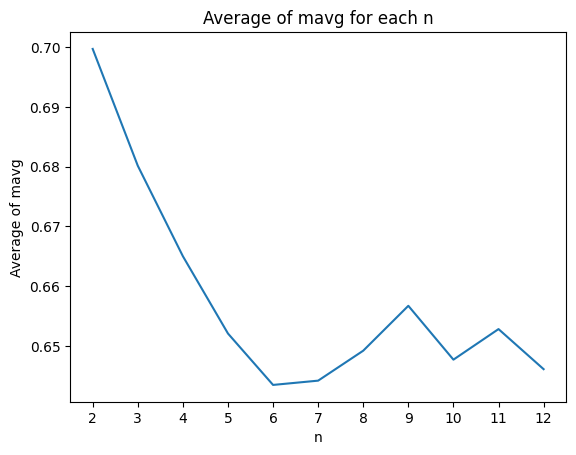

In [20]:
sns.lineplot(x='n', y='mavg', data=spherical_n)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
plt.xticks(ticks=spherical_n['n'].values, labels=spherical_n['n'].values)
plt.savefig("../regression_files/regression_figures/mavg/spherical_n.png")

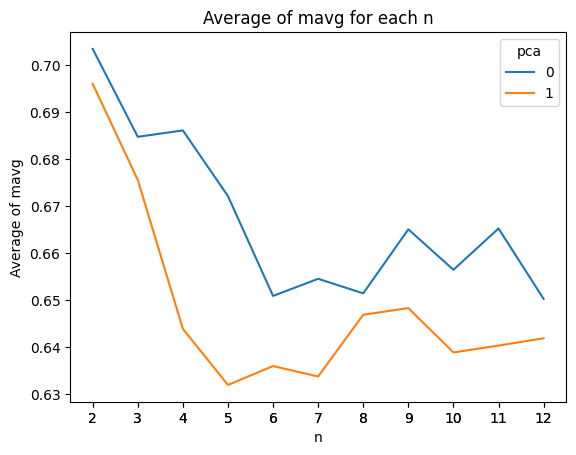

In [21]:
sns.lineplot(x='n', y='mavg', hue="pca", data=spherical_n_pca)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
plt.xticks(ticks=spherical_n_pca['n'].values, labels=spherical_n_pca['n'].values)
plt.savefig("../regression_files/regression_figures/mavg/spherical_n_pca.png")

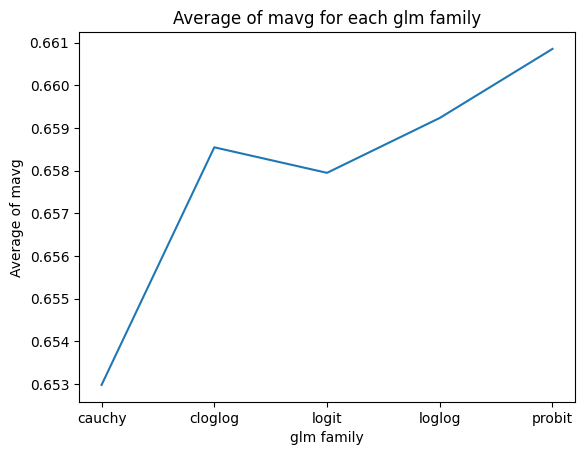

In [22]:
sns.lineplot(x='glm_family', y='mavg', data=spherical_glm)

# Add labels and title
plt.xlabel('glm family')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each glm family')
plt.savefig("../regression_files/regression_figures/mavg/spherical_glm.png")

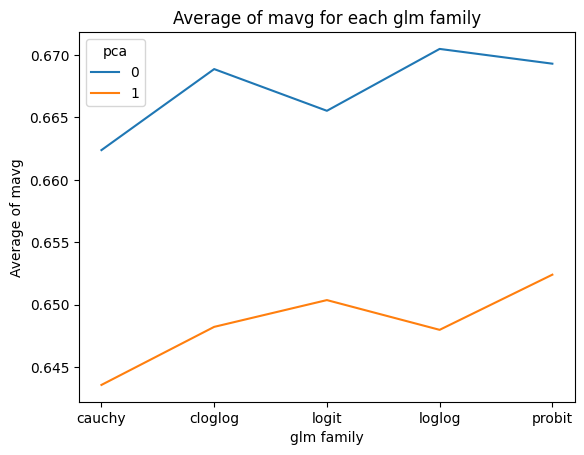

In [23]:
sns.lineplot(x='glm_family', y='mavg', hue="pca", data=spherical_glm_pca)

# Add labels and title
plt.xlabel('glm family')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each glm family')
plt.savefig("../regression_files/regression_figures/mavg/spherical_n_pca.png")

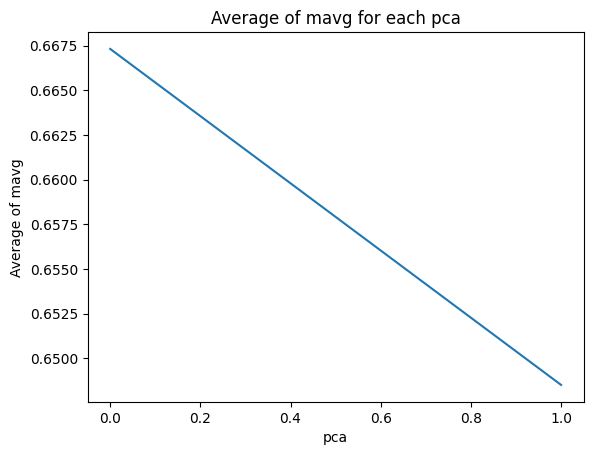

In [24]:
sns.lineplot(x='pca', y='mavg', data=spherical_pca)

# Add labels and title
plt.xlabel('pca')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each pca')
plt.savefig("../regression_files/regression_figures/mavg/spherical_pca.png")

## Full

In [25]:
full.sort_values(by="mavg", ascending=False)

,model,mavg,glm_family,cov,n,pca
13,full_3,0.719126,loglog,full,3,0
3,full_2,0.716286,loglog,full,2,0
40,full_6,0.716053,logit,full,6,0
43,full_6,0.714586,loglog,full,6,0
53,full_7,0.713649,loglog,full,7,0
...,...,...,...,...,...,...
78,full_9_pca,0.668546,loglog,full,9,1
107,full_12_pca,0.667652,cauchy,full,12,1
57,full_7_pca,0.666256,cauchy,full,7,1
75,full_9_pca,0.665536,logit,full,9,1


In [26]:
full_n = full.groupby('n')['mavg'].mean().reset_index()
full_glm = full.groupby('glm_family')['mavg'].mean().reset_index()
full_n_pca = full.groupby(['n','pca'])['mavg'].mean().reset_index()
full_glm_pca = full.groupby(['glm_family','pca'])['mavg'].mean().reset_index()
full_pca = full.groupby(['pca'])['mavg'].mean().reset_index()

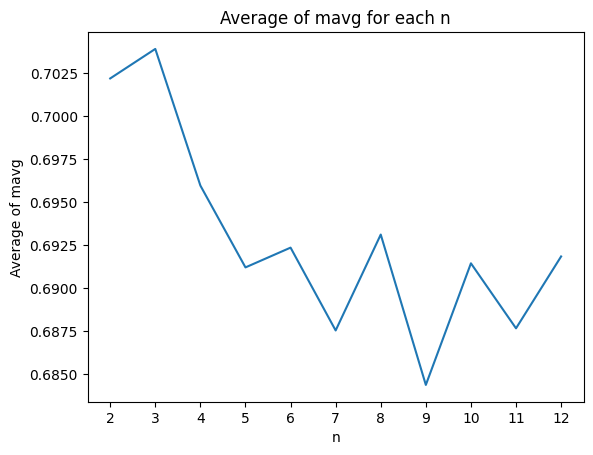

In [27]:
sns.lineplot(x='n', y='mavg', data=full_n)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
plt.xticks(ticks=full_n['n'].values, labels=full_n['n'].values)
plt.savefig("../regression_files/regression_figures/mavg/full_n.png")

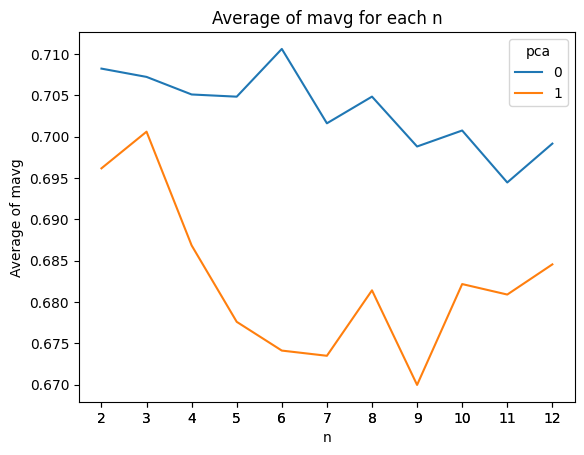

In [28]:
sns.lineplot(x='n', y='mavg', hue="pca", data=full_n_pca)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
plt.xticks(ticks=full_n_pca['n'].values, labels=full_n_pca['n'].values)
plt.savefig("../regression_files/regression_figures/mavg/full_n_pca.png")

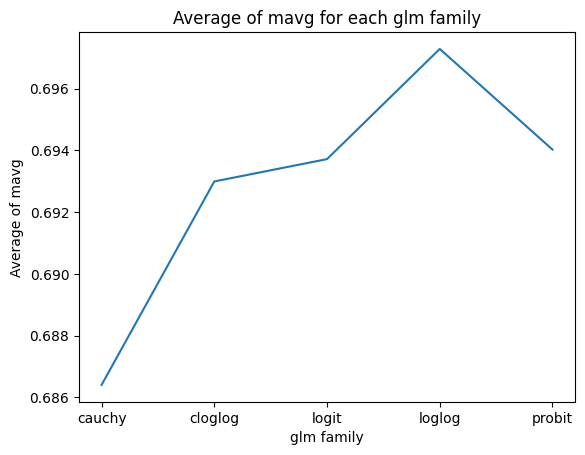

In [29]:
sns.lineplot(x='glm_family', y='mavg', data=full_glm)

# Add labels and title
plt.xlabel('glm family')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each glm family')
plt.savefig("../regression_files/regression_figures/mavg/full_glm.png")

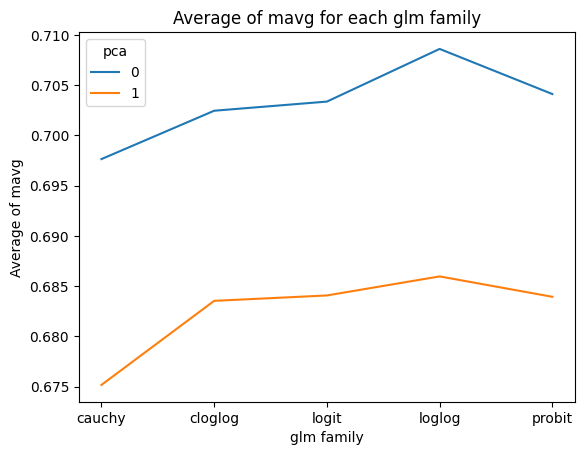

In [30]:
sns.lineplot(x='glm_family', y='mavg', hue="pca", data=full_glm_pca)

# Add labels and title
plt.xlabel('glm family')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each glm family')
plt.savefig("../regression_files/regression_figures/mavg/full_glm_pca.png")

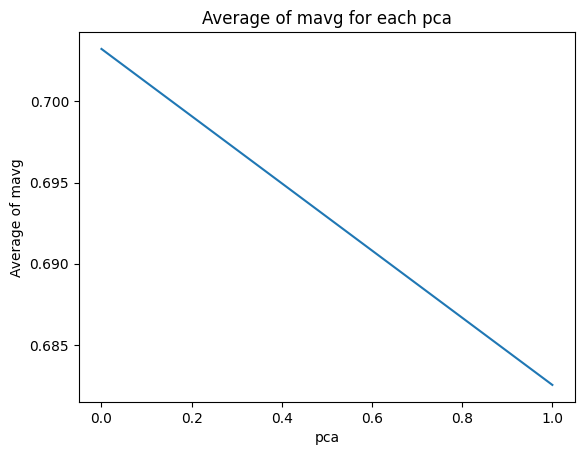

In [31]:
sns.lineplot(x='pca', y='mavg', data=full_pca)

# Add labels and title
plt.xlabel('pca')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each pca')
plt.savefig("../regression_files/regression_figures/mavg/full_pca.png")

## Tied

In [32]:
tied.sort_values(by="mavg", ascending=False)

,model,mavg,glm_family,cov,n,pca
60,tied_8,0.716068,logit,tied,8,0
43,tied_6,0.715224,loglog,tied,6,0
33,tied_5,0.711700,loglog,tied,5,0
41,tied_6,0.711266,probit,tied,6,0
3,tied_2,0.710577,loglog,tied,2,0
...,...,...,...,...,...,...
82,tied_10,0.627738,cauchy,tied,10,0
107,tied_12_pca,0.627393,cauchy,tied,12,1
106,tied_12_pca,0.626107,probit,tied,12,1
92,tied_11,0.624590,cauchy,tied,11,0


In [33]:
tied_n = tied.groupby('n')['mavg'].mean().reset_index()
tied_glm = tied.groupby('glm_family')['mavg'].mean().reset_index()
tied_n_pca = tied.groupby(['n','pca'])['mavg'].mean().reset_index()
tied_glm_pca = tied.groupby(['glm_family','pca'])['mavg'].mean().reset_index()
tied_pca = tied.groupby(['pca'])['mavg'].mean().reset_index()

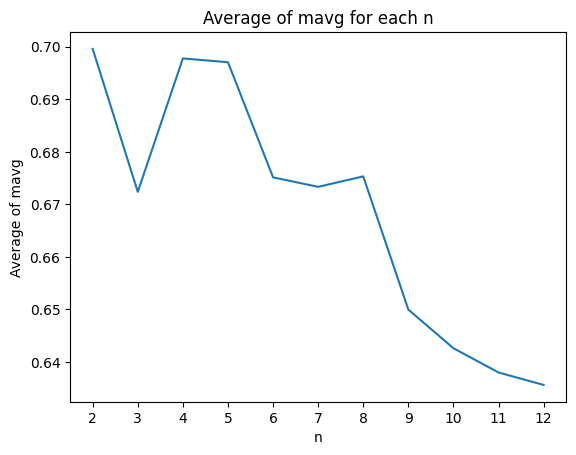

In [34]:
sns.lineplot(x='n', y='mavg', data=tied_n)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
plt.xticks(ticks=tied_n['n'].values, labels=tied_n['n'].values)
plt.savefig("../regression_files/regression_figures/mavg/tied_n.png")

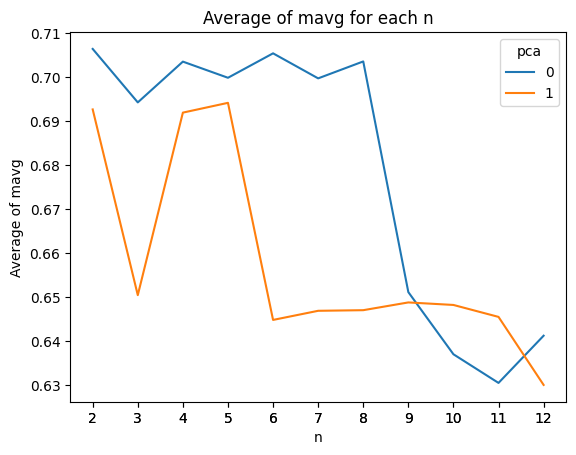

In [35]:
sns.lineplot(x='n', y='mavg', hue="pca", data=tied_n_pca)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
plt.xticks(ticks=tied_n_pca['n'].values, labels=tied_n_pca['n'].values)
plt.savefig("../regression_files/regression_figures/mavg/tied_n_pca.png")

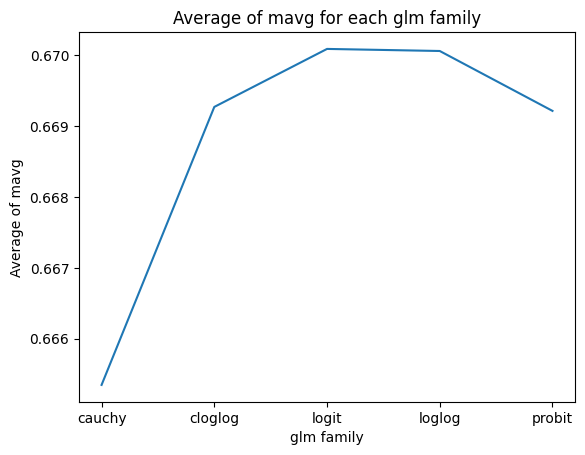

In [36]:
sns.lineplot(x='glm_family', y='mavg', data=tied_glm)

# Add labels and title
plt.xlabel('glm family')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each glm family')
plt.savefig("../regression_files/regression_figures/mavg/tied_glm.png")

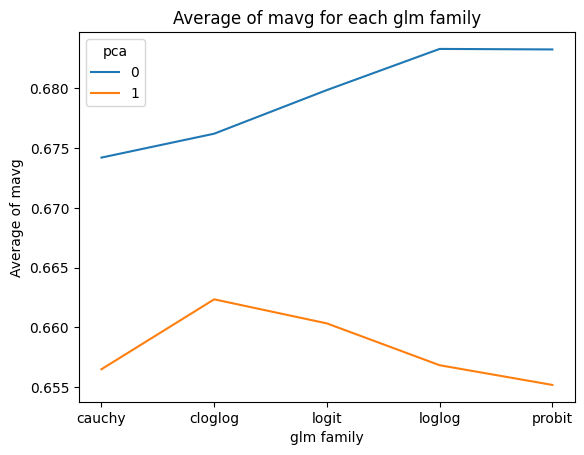

In [37]:
sns.lineplot(x='glm_family', y='mavg', hue="pca", data=tied_glm_pca)

# Add labels and title
plt.xlabel('glm family')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each glm family')
plt.savefig("../regression_files/regression_figures/mavg/tied_n_pca.png")

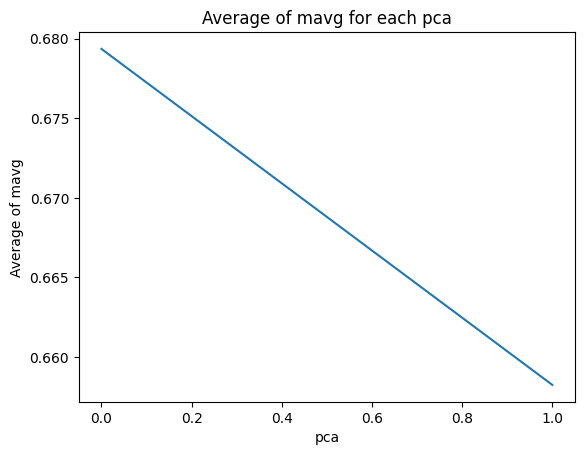

In [38]:
sns.lineplot(x='pca', y='mavg', data=tied_pca)

# Add labels and title
plt.xlabel('pca')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each pca')
plt.savefig("../regression_files/regression_figures/mavg/tied_pca.png")

## Diag

In [39]:
diag.sort_values(by="mavg", ascending=False)

,model,mavg,glm_family,cov,n,pca
33,diag_5,0.714545,loglog,diag,5,0
31,diag_5,0.713054,probit,diag,5,0
8,diag_2_pca,0.712862,loglog,diag,2,1
83,diag_10,0.711509,loglog,diag,10,0
14,diag_3,0.711176,cloglog,diag,3,0
...,...,...,...,...,...,...
75,diag_9_pca,0.644561,logit,diag,9,1
69,diag_8_pca,0.644268,cloglog,diag,8,1
107,diag_12_pca,0.644009,cauchy,diag,12,1
85,diag_10_pca,0.641149,logit,diag,10,1


In [40]:
diag_n = diag.groupby('n')['mavg'].mean().reset_index()
diag_glm = diag.groupby('glm_family')['mavg'].mean().reset_index()
diag_n_pca = diag.groupby(['n','pca'])['mavg'].mean().reset_index()
diag_glm_pca = diag.groupby(['glm_family','pca'])['mavg'].mean().reset_index()
diag_pca = diag.groupby(['pca'])['mavg'].mean().reset_index()

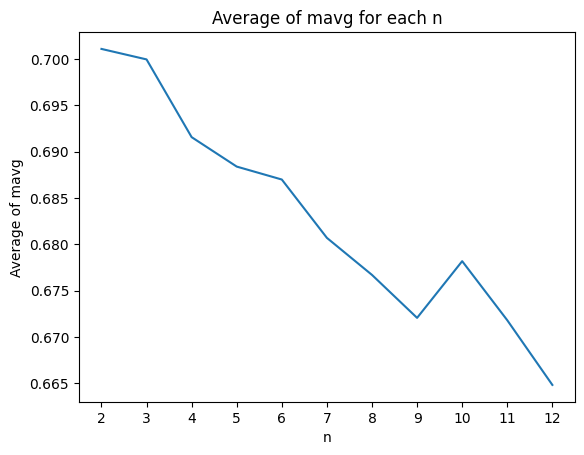

In [41]:
sns.lineplot(x='n', y='mavg', data=diag_n)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
plt.xticks(ticks=diag_n['n'].values, labels=diag_n['n'].values)
plt.savefig("../regression_files/regression_figures/mavg/diag_n.png")

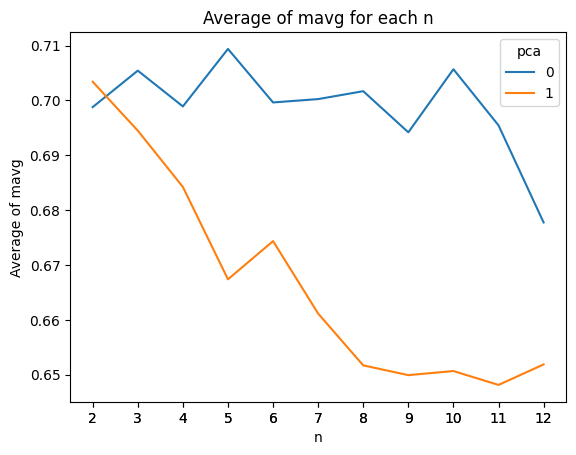

In [42]:
sns.lineplot(x='n', y='mavg', hue="pca", data=diag_n_pca)

# Add labels and title
plt.xlabel('n')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each n')
plt.xticks(ticks=diag_n_pca['n'].values, labels=diag_n_pca['n'].values)
plt.savefig("../regression_files/regression_figures/mavg/diag_n_pca.png")

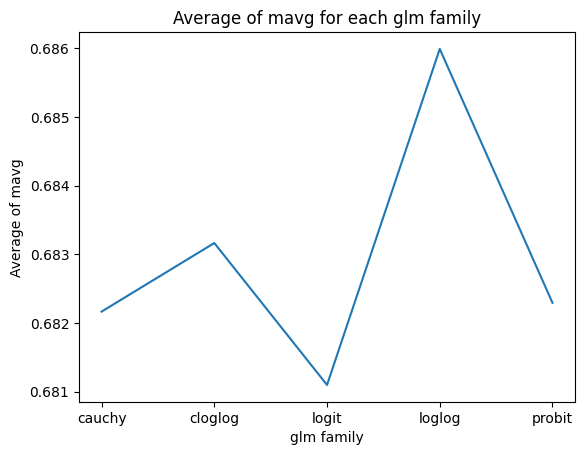

In [43]:
sns.lineplot(x='glm_family', y='mavg', data=diag_glm)

# Add labels and title
plt.xlabel('glm family')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each glm family')
plt.savefig("../regression_files/regression_figures/mavg/diag_glm.png")

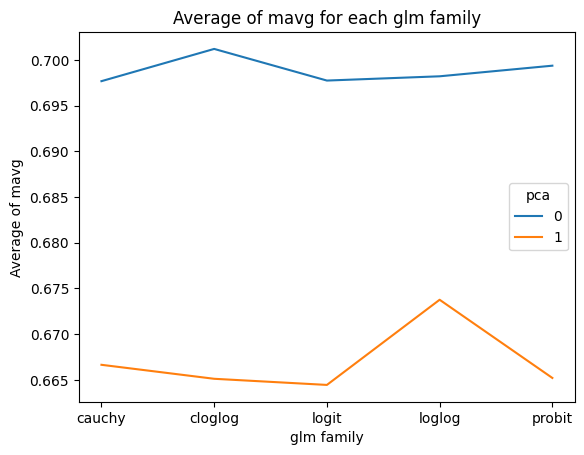

In [44]:
sns.lineplot(x='glm_family', y='mavg', hue="pca", data=diag_glm_pca)

# Add labels and title
plt.xlabel('glm family')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each glm family')
plt.savefig("../regression_files/regression_figures/mavg/diag_glm_pca.png")

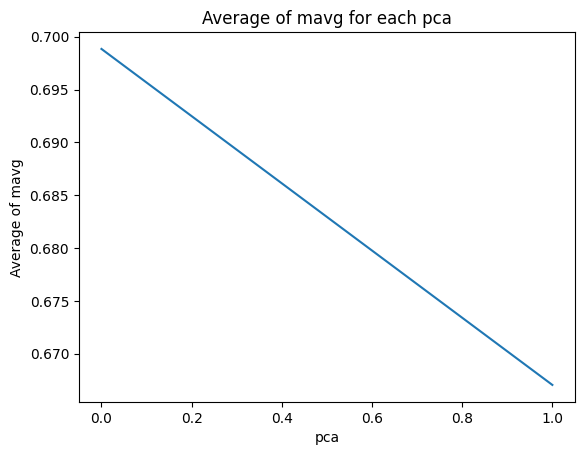

In [45]:
sns.lineplot(x='pca', y='mavg', data=diag_pca)

# Add labels and title
plt.xlabel('pca')
plt.ylabel('Average of mavg')
plt.title('Average of mavg for each pca')
plt.savefig("../regression_files/regression_figures/mavg/diag_pca.png")